In [1]:
import seaborn as sns

sns.set_theme(style="dark")

In [2]:
import pandas as pd

EVAL_DB_DIR = "../../deb65416_creastorygen.csv"

users = pd.read_csv(EVAL_DB_DIR + "/deb65416_creastorygen_table_user.csv")
sessions = pd.read_csv(EVAL_DB_DIR + "/deb65416_creastorygen_table_session.csv")
stories = pd.read_csv(EVAL_DB_DIR + "/deb65416_creastorygen_table_story.csv")
evals = pd.read_csv(EVAL_DB_DIR + "/deb65416_creastorygen_table_creativity_eval.csv")

TEST_USER_IDS = [1]

# users whose username start with cs-gen
TEST_USER_IDS += users.query("username.str.startswith('cs-gen')", engine='python').user_id.to_list()

In [3]:
TEST_USER_IDS

[1, 100, 101]

In [4]:
# drop all users that are not in the test set
users = users[~users["user_id"].isin(TEST_USER_IDS)]
sessions = sessions[~sessions["user_id"].isin(TEST_USER_IDS)]
evals = evals[~evals["user_id"].isin(TEST_USER_IDS)]

In [5]:
len(users), len(sessions), len(evals)

(98, 98, 2232)

In [6]:
# count number of incomplete sessions and evals
incomplete_sessions = sessions.query("status == 'started'")
incomplete_evals = evals.query("status == 'started'")
quit_sessions = sessions.query("status == 'quit'")

len(incomplete_sessions), len(incomplete_evals), len(quit_sessions)

(8, 72, 0)

In [7]:
# drop incomplete evaluations and sessions
evals = evals[evals["status"] == "completed"]
sessions = sessions[sessions["status"] == "completed"]

In [8]:
len(sessions), len(evals)

(90, 2160)

In [9]:
# merge stories and evals
evals = pd.merge(evals, stories, on="story_id", how="left")
len(evals)

2160

In [10]:
# count number of unique users
evals.user_id.nunique()

90

In [11]:
# check if all users have evaluated 24 stories
(evals.groupby("user_id").story_id.nunique() == 24).sum()

90

In [12]:
# average time spent on a story
study_time = pd.to_datetime(sessions["endtime"]) - pd.to_datetime(sessions["starttime"])
study_time.mean()

Timedelta('0 days 00:22:47.444444444')

<Axes: ylabel='Count'>

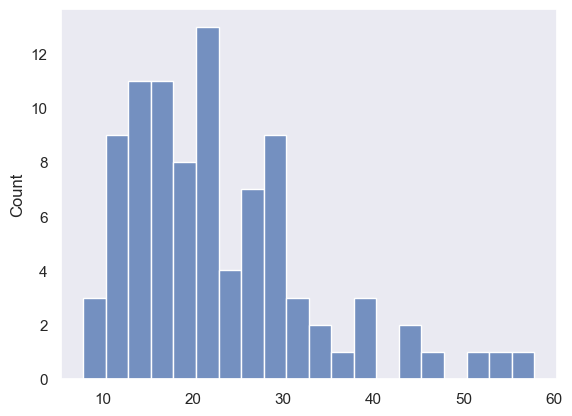

In [13]:
# plot study time
sns.histplot(study_time.dt.total_seconds() / 60, bins=20)

In [14]:
evals.story_id.nunique()

400

In [13]:
evals.head()

,eval_id,user_id,story_id,session_id,status,creativity,originality,surprise,value,author,story_ext_id,story_item_id,story_author
0,25,2,253,2,completed,5.0,4.0,2.0,4.0,human,R_8LtUJwc0nMwsLzG_Q2,stamp-letter-send,human
1,26,2,6,2,completed,2.0,1.0,1.0,3.0,AI,f3ec3e93fa8b,stamp-letter-send,AI
2,27,2,2,2,completed,4.0,5.0,4.0,4.0,AI,9ca6a441cfd5,stamp-letter-send,AI
3,28,2,245,2,completed,2.0,4.0,2.0,2.0,human,R_8WxkYgki5yinZhV_Q2,stamp-letter-send,human
4,29,2,121,2,completed,5.0,5.0,2.0,4.0,human,4550c7034f90,stamp-letter-send,AI


In [14]:
evals = pd.merge(evals, sessions, on=["user_id", "session_id"], how="left")

In [15]:
evals.head()

,eval_id,user_id_x,story_id,session_id,status_x,creativity,originality,surprise,value,author,story_ext_id,story_item_id,story_author,user_id_y,starttime,endtime,status_y,eval_comments,comments
0,25,2,253,2,completed,5.0,4.0,2.0,4.0,human,R_8LtUJwc0nMwsLzG_Q2,stamp-letter-send,human,2,2025-01-13 09:16:42,2025-01-13 09:41:57,completed,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...
1,26,2,6,2,completed,2.0,1.0,1.0,3.0,AI,f3ec3e93fa8b,stamp-letter-send,AI,2,2025-01-13 09:16:42,2025-01-13 09:41:57,completed,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...
2,27,2,2,2,completed,4.0,5.0,4.0,4.0,AI,9ca6a441cfd5,stamp-letter-send,AI,2,2025-01-13 09:16:42,2025-01-13 09:41:57,completed,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...
3,28,2,245,2,completed,2.0,4.0,2.0,2.0,human,R_8WxkYgki5yinZhV_Q2,stamp-letter-send,human,2,2025-01-13 09:16:42,2025-01-13 09:41:57,completed,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...
4,29,2,121,2,completed,5.0,5.0,2.0,4.0,human,4550c7034f90,stamp-letter-send,AI,2,2025-01-13 09:16:42,2025-01-13 09:41:57,completed,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...


In [16]:
evals = evals.rename(columns={"author": "pred_author", "story_author": "ref_author", "user_id_x": "user_id"})

In [19]:
evals = evals.drop(columns=["user_id_y", "status_x", "status_y"])
evals["study_time"] = pd.to_datetime(evals["endtime"]) - pd.to_datetime(evals["starttime"])
evals["study_time_in_mins"] = evals["study_time"].apply(lambda x: x.total_seconds() / 60)

In [20]:
evals.head()

,eval_id,user_id,story_id,session_id,creativity,originality,surprise,value,pred_author,story_ext_id,story_item_id,ref_author,starttime,endtime,eval_comments,comments,study_time,study_time_in_mins
0,25,2,253,2,5.0,4.0,2.0,4.0,human,R_8LtUJwc0nMwsLzG_Q2,stamp-letter-send,human,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25
1,26,2,6,2,2.0,1.0,1.0,3.0,AI,f3ec3e93fa8b,stamp-letter-send,AI,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25
2,27,2,2,2,4.0,5.0,4.0,4.0,AI,9ca6a441cfd5,stamp-letter-send,AI,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25
3,28,2,245,2,2.0,4.0,2.0,2.0,human,R_8WxkYgki5yinZhV_Q2,stamp-letter-send,human,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25
4,29,2,121,2,5.0,5.0,2.0,4.0,human,4550c7034f90,stamp-letter-send,AI,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25


In [21]:
evals.to_csv("../human_eval/raw_non_expert_data.csv", index=False)

In [15]:
per_story_evals = evals.groupby("story_id").agg({"user_id": "count"}).sort_values("user_id", ascending=False).reset_index()
control_story_evals = per_story_evals[per_story_evals["user_id"] > 5]
len(control_story_evals)

16

In [22]:
CONTROL1_EXT_STORY_IDS = ["8d4cce7f122d", "e7745b30528b", "R_2XcT1LBVLYHa6hX_Q3", "R_8K7NzHgqM00gKVF_Q4"]
CONTROL2_EXT_STORY_IDS = ["R_8U0c5Ms0PJ9VYTm_Q2", "R_2JzuWAk6bRQPato_Q1", "50a0b00eb07f", "2cf519f6ff39"]
CONTROL3_EXT_STORY_IDS = ["4550c7034f90", "R_8kQG02fwq7ubaOB_Q1", "e3e4310f8c04", "R_2Ep8Ymfq8uSEw90_Q4"]
CONTROL4_EXT_STORY_IDS = ["R_8LtUJwc0nMwsLzG_Q2", "52cade8daeea", "R_2sKl3oqSfQrqNI5_Q3", "13f2217b9d4c"]

CONTROL_EXT_STORY_IDS = CONTROL1_EXT_STORY_IDS + CONTROL2_EXT_STORY_IDS + CONTROL3_EXT_STORY_IDS + CONTROL4_EXT_STORY_IDS

CONTROL1_STORY_IDS = stories[stories["story_ext_id"].isin(CONTROL1_EXT_STORY_IDS)].story_id.to_list()
CONTROL2_STORY_IDS = stories[stories["story_ext_id"].isin(CONTROL2_EXT_STORY_IDS)].story_id.to_list()
CONTROL3_STORY_IDS = stories[stories["story_ext_id"].isin(CONTROL3_EXT_STORY_IDS)].story_id.to_list()
CONTROL4_STORY_IDS = stories[stories["story_ext_id"].isin(CONTROL4_EXT_STORY_IDS)].story_id.to_list()

CONTROL_STORY_IDS = CONTROL1_STORY_IDS + CONTROL2_STORY_IDS + CONTROL3_STORY_IDS + CONTROL4_STORY_IDS


In [23]:
evals["control_story"] = evals["story_id"].isin(CONTROL_STORY_IDS)

In [24]:
evals.head()

,eval_id,user_id,story_id,session_id,creativity,originality,surprise,value,pred_author,story_ext_id,story_item_id,ref_author,starttime,endtime,eval_comments,comments,study_time,study_time_in_mins,control_story
0,25,2,253,2,5.0,4.0,2.0,4.0,human,R_8LtUJwc0nMwsLzG_Q2,stamp-letter-send,human,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25,True
1,26,2,6,2,2.0,1.0,1.0,3.0,AI,f3ec3e93fa8b,stamp-letter-send,AI,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25,False
2,27,2,2,2,4.0,5.0,4.0,4.0,AI,9ca6a441cfd5,stamp-letter-send,AI,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25,False
3,28,2,245,2,2.0,4.0,2.0,2.0,human,R_8WxkYgki5yinZhV_Q2,stamp-letter-send,human,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25,False
4,29,2,121,2,5.0,5.0,2.0,4.0,human,4550c7034f90,stamp-letter-send,AI,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25,True


In [17]:
# check control stories
(set(control_story_evals.story_id.to_list()) - set(CONTROL_STORY_IDS)) == set()

True

In [18]:
evals.head()

,eval_id,user_id,story_id,session_id,status,creativity,originality,surprise,value,author,story_ext_id,story_item_id,story_author
0,25,2,253,2,completed,5.0,4.0,2.0,4.0,human,R_8LtUJwc0nMwsLzG_Q2,stamp-letter-send,human
1,26,2,6,2,completed,2.0,1.0,1.0,3.0,AI,f3ec3e93fa8b,stamp-letter-send,AI
2,27,2,2,2,completed,4.0,5.0,4.0,4.0,AI,9ca6a441cfd5,stamp-letter-send,AI
3,28,2,245,2,completed,2.0,4.0,2.0,2.0,human,R_8WxkYgki5yinZhV_Q2,stamp-letter-send,human
4,29,2,121,2,completed,5.0,5.0,2.0,4.0,human,4550c7034f90,stamp-letter-send,AI


In [25]:
evals.to_csv("../human_eval/raw_non_expert_data.csv", index=False)

In [26]:
evals.groupby("story_id").agg({"eval_id": "count"})["eval_id"].value_counts()

eval_id
5     306
4      46
3      21
2       6
1       5
22      4
24      4
21      4
23      2
25      1
27      1
Name: count, dtype: int64

In [27]:
complete_story_ids = evals.groupby("story_id").agg({"eval_id": "count"}).query("eval_id == 5").index.to_list()
len(complete_story_ids)

306

In [28]:
# drop incomplete and control stories
evals = evals[evals["story_id"].isin(complete_story_ids)]

In [24]:
stories.head()

,story_id,story_ext_id,story_item_id,story_author
0,1,976672582036,petrol-diesel-pump,AI
1,2,9ca6a441cfd5,stamp-letter-send,AI
2,3,25795f8e5bee,organ-empire-comply,AI
3,4,d75a72efa018,gloom-payment-exist,AI
4,5,7c8448fb1129,petrol-diesel-pump,AI


In [29]:
from metrics import get_sentences
from utils import read_json

# drop stories with less than 3 or more than 7 sentences
eval_data = read_json("../experiments/human_eval/eval_data.json")
keep_story_ids = []

for i, row in stories.iterrows():
    ext_id = row["story_ext_id"]
    story_data = eval_data[ext_id]
    sentences = get_sentences(story_data["text"])
    if 3 <= len(sentences) <= 7:
        keep_story_ids.append(row["story_id"])

/Users/mismayil/.pyenv/versions/cs-gen/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Loading spacy engine: en_core_web_sm


In [30]:
len(keep_story_ids)

431

In [31]:
len(evals), evals.story_id.nunique()

(1530, 306)

In [32]:
evals = evals[evals["story_id"].isin(keep_story_ids)]

In [33]:
len(evals)

1365

In [34]:
evals.to_csv("../human_eval/filtered_non_expert_data.csv", index=False)

In [31]:
# raw creativity score averages by predicted author
evals.groupby("author").agg({"creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean"}).reset_index()

,author,creativity,originality,surprise,value
0,AI,3.345238,3.193878,2.826531,3.059524
1,human,2.929215,2.899614,2.535393,2.970399


In [32]:
# raw creativity score averages by reference author
evals.groupby("story_author").agg({"creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean"}).reset_index()

,story_author,creativity,originality,surprise,value
0,AI,3.622695,3.405674,2.990071,3.243972
1,human,2.559091,2.621212,2.309091,2.757576


In [33]:
# raw turing pass rate
evals["turing_pass"] = evals["author"] == evals["story_author"]
evals["turing_pass"].sum() / len(evals)

0.7018315018315018

<Axes: xlabel='value', ylabel='Count'>

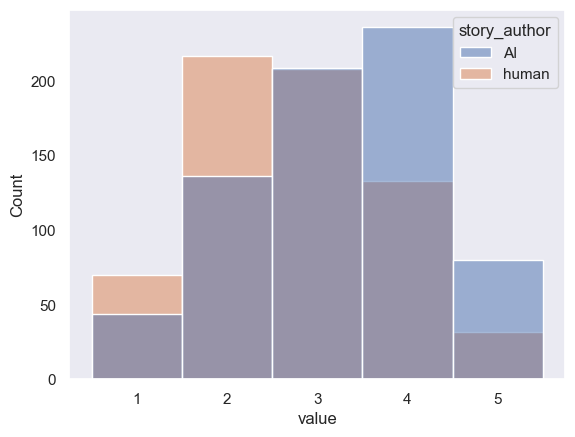

In [42]:
sns.histplot(evals, x="value", hue="story_author", discrete=True, bins=5)

<Axes: xlabel='value', ylabel='Count'>

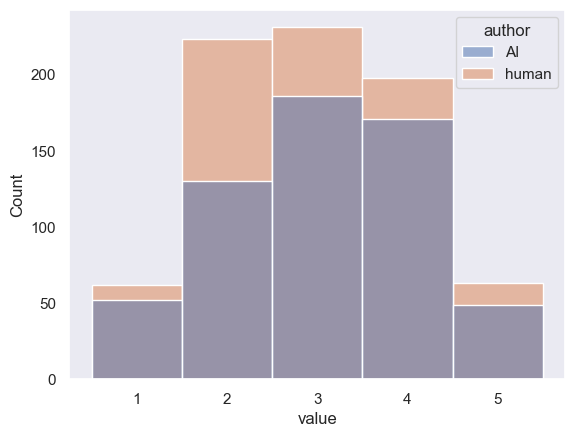

In [46]:
sns.histplot(evals, x="value", hue="author", discrete=True, bins=5)

In [47]:
# raw creativity score averages by reference author grouped by story id
evals.groupby(["story_id", "story_author"]).agg({"creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean"}).groupby("story_author").mean().reset_index()

,story_author,creativity,originality,surprise,value
0,AI,3.622695,3.405674,2.990071,3.243972
1,human,2.559091,2.621212,2.309091,2.757576


In [49]:
# filter incorrect evaluations
correct_evals = evals[evals["turing_pass"]]

In [50]:
correct_evals.groupby(["story_id", "story_author"]).agg({"creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean"})

,,creativity,originality,surprise,value
story_id,story_author,,,,
11,AI,4.250000,4.00,3.75,2.750000
12,AI,5.000000,4.00,4.00,3.333333
13,AI,4.000000,3.75,4.00,3.250000
14,AI,4.600000,4.20,3.40,3.800000
15,AI,4.200000,4.00,2.80,2.600000
...,...,...,...,...,...
427,human,2.333333,2.00,1.00,3.666667
428,human,2.000000,1.80,1.60,2.400000
430,human,2.500000,2.25,2.25,3.250000


In [51]:
# count number of human and AI evals
len(evals[evals["story_author"] == "AI"]), len(evals[evals["story_author"] == "human"])

(705, 660)

In [52]:
# false positive AI and human rate
len(evals[(evals["story_author"] == "AI") & (evals["author"] == "human")]) / len(evals[evals["story_author"] == "AI"]), len(evals[(evals["story_author"] == "human") & (evals["author"] == "AI")]) / len(evals[evals["story_author"] == "human"])

(0.37163120567375885, 0.2196969696969697)

In [53]:
# raw creativity score averages by reference author on correct evaluations
correct_evals.groupby(["story_id", "story_author"]).agg({"creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean"}).groupby("story_author").mean().reset_index()

,story_author,creativity,originality,surprise,value
0,AI,3.556667,3.314524,2.931310,3.156786
1,human,2.579293,2.636616,2.289015,2.777525


In [54]:
def agg_author(df):
    return pd.Series({
        "user_id": df["user_id"].count(),
        "author_AI": (df["author"] == "AI").sum(),
        "author_human": (df["author"] == "human").sum(),
        "maj_author": df["author"].mode().values[0],
    })
evals_by_authors = evals.groupby(["story_id", "story_author"]).apply(agg_author, include_groups=False).reset_index()

In [55]:
evals_by_authors.head()

,story_id,story_author,user_id,author_AI,author_human,maj_author
0,11,AI,5,4,1,AI
1,12,AI,5,3,2,AI
2,13,AI,5,4,1,AI
3,14,AI,5,5,0,AI
4,15,AI,5,5,0,AI


In [57]:
(evals_by_authors["story_author"] == evals_by_authors["maj_author"]).sum() / len(evals_by_authors)

0.8095238095238095

In [58]:
# count stories that miss items
from utils import read_json

eval_story_ids = list(set(evals.story_id.to_list()))
eval_ext_story_ids = stories[stories["story_id"].isin(eval_story_ids)].story_ext_id.to_list()

eval_data = read_json("../experiments/human_eval/eval_data.json")
stories_missing_items = []
stories_no_items = []

for ext_id in eval_ext_story_ids:
    story_data = eval_data[ext_id]
    items = story_data["item_id"].split("-")
    story_text = story_data["text"].lower()
    num_contained_items = 0
    for item in items:
        if item in story_text:
            num_contained_items += 1
    if num_contained_items == 0:
        stories_no_items.append(ext_id)
    if num_contained_items < len(items):
        stories_missing_items.append(ext_id)

len(stories_missing_items), len(stories_no_items)

(29, 2)

In [59]:
evals.head()

,eval_id,user_id,story_id,session_id,status,creativity,originality,surprise,value,author,story_ext_id,story_item_id,story_author,turing_pass
21,46,2,12,2,completed,5.0,3.0,4.0,4.0,AI,b3f45a6140f9,gloom-payment-exist,AI,True
35,60,3,252,3,completed,2.0,2.0,2.0,3.0,human,R_8LtUJwc0nMwsLzG_Q1,petrol-diesel-pump,human,True
38,63,3,11,3,completed,3.0,3.0,3.0,1.0,AI,b65a1a3c906d,organ-empire-comply,AI,True
57,82,4,252,4,completed,5.0,5.0,5.0,5.0,human,R_8LtUJwc0nMwsLzG_Q1,petrol-diesel-pump,human,True
64,89,4,11,4,completed,5.0,5.0,3.0,2.0,AI,b65a1a3c906d,organ-empire-comply,AI,True


In [60]:
evals[(evals["value"] < 3) & (evals["story_author"] == "human")]

,eval_id,user_id,story_id,session_id,status,creativity,originality,surprise,value,author,story_ext_id,story_item_id,story_author,turing_pass
74,123,7,261,7,completed,1.0,1.0,1.0,2.0,human,R_8d77LowRrq3xFfJ_Q2,stamp-letter-send,human,True
77,126,7,257,7,completed,1.0,2.0,1.0,1.0,AI,R_2YKQTEPFuU2GBvV_Q2,stamp-letter-send,human,False
80,129,7,256,7,completed,2.0,2.0,2.0,2.0,human,R_2YKQTEPFuU2GBvV_Q1,petrol-diesel-pump,human,True
81,130,7,260,7,completed,2.0,2.0,1.0,2.0,human,R_8d77LowRrq3xFfJ_Q1,petrol-diesel-pump,human,True
91,140,7,263,7,completed,1.0,1.0,1.0,2.0,human,R_8d77LowRrq3xFfJ_Q4,gloom-payment-exist,human,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072,2169,76,428,76,completed,1.0,1.0,1.0,2.0,human,R_8DSuE0JfUBgPxHX_Q1,petrol-diesel-pump,human,True
2080,2177,76,434,76,completed,1.0,1.0,1.0,2.0,human,R_2LTbPAQf8NZ0wRb_Q3,organ-empire-comply,human,True
2084,2181,76,427,76,completed,2.0,2.0,1.0,2.0,human,R_2mqjhNO26XNoi6R_Q4,gloom-payment-exist,human,True
2104,2201,80,430,80,completed,1.0,2.0,2.0,2.0,human,R_8DSuE0JfUBgPxHX_Q3,organ-empire-comply,human,True


In [61]:
# categorize by item ids
item_ids = evals.story_item_id.unique().tolist()
eval_by_item_ids = []

for item_id in item_ids:
    eval_by_item_id = evals[evals["story_item_id"] == item_id]
    eval_by_item_ids.append(eval_by_item_id)

In [62]:
eval_by_item_ids[0].groupby(["story_id", "story_author"]).agg({"creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean"}).groupby("story_author").mean().reset_index()

,story_author,creativity,originality,surprise,value
0,AI,3.702857,3.525714,3.154286,3.331429
1,human,2.525000,2.593750,2.231250,2.800000


In [63]:
eval_by_item_ids[1].groupby(["story_id", "story_author"]).agg({"creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean"}).groupby("story_author").mean().reset_index()

,story_author,creativity,originality,surprise,value
0,AI,3.616667,3.411111,2.916667,3.166667
1,human,2.618182,2.587879,2.381818,2.745455


In [64]:
eval_by_item_ids[2].groupby(["story_id", "story_author"]).agg({"creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean"}).groupby("story_author").mean().reset_index()

,story_author,creativity,originality,surprise,value
0,AI,3.582857,3.314286,2.994286,3.154286
1,human,2.705882,2.705882,2.388235,2.723529


In [65]:
eval_by_item_ids[3].groupby(["story_id", "story_author"]).agg({"creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean"}).groupby("story_author").mean().reset_index()

,story_author,creativity,originality,surprise,value
0,AI,3.588571,3.371429,2.897143,3.325714
1,human,2.381818,2.593939,2.230303,2.763636


In [66]:
# analyze ratings across time
evals_by_users = []

for user_id in evals.user_id.unique():
    eval_by_user = evals[evals["user_id"] == user_id].copy()
    eval_by_user = eval_by_user.sort_values("eval_id")
    eval_by_user["timepoint"] = list(range(1, len(eval_by_user) + 1))
    evals_by_users.append(eval_by_user)

evals_with_tp = pd.concat(evals_by_users)

<Axes: xlabel='timepoint', ylabel='value'>

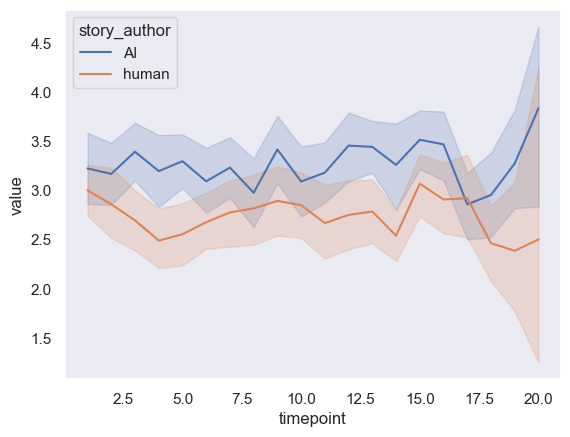

In [71]:
# plot creativity ratings over time
sns.lineplot(data=evals_with_tp, x="timepoint", y="value", hue="story_author")

<Axes: xlabel='timepoint', ylabel='value'>

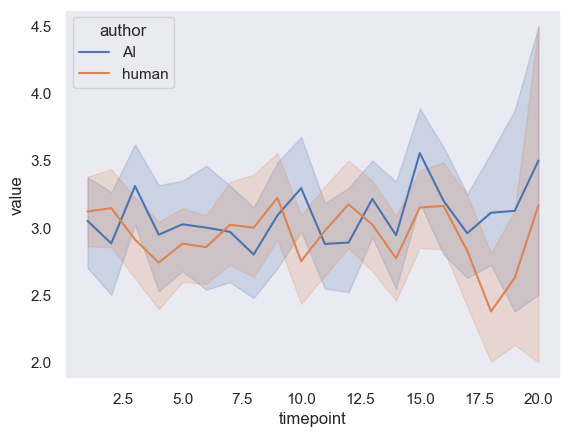

In [75]:
# plot originality ratings over time
sns.lineplot(data=evals_with_tp, x="timepoint", y="value", hue="author")

<Axes: xlabel='timepoint', ylabel='turing_pass'>

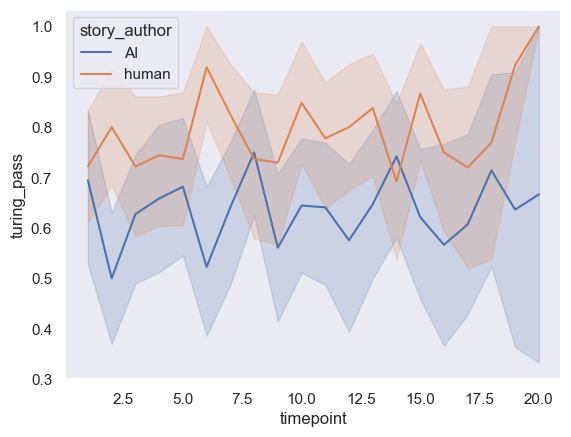

In [299]:
# plot turing pass ratings over time
sns.lineplot(data=evals_with_tp, x="timepoint", y="turing_pass", hue="story_author")

In [76]:
evals_with_tp.head()

,eval_id,user_id,story_id,session_id,status,creativity,originality,surprise,value,author,story_ext_id,story_item_id,story_author,turing_pass,timepoint
21,46,2,12,2,completed,5.0,3.0,4.0,4.0,AI,b3f45a6140f9,gloom-payment-exist,AI,True,1
35,60,3,252,3,completed,2.0,2.0,2.0,3.0,human,R_8LtUJwc0nMwsLzG_Q1,petrol-diesel-pump,human,True,1
38,63,3,11,3,completed,3.0,3.0,3.0,1.0,AI,b65a1a3c906d,organ-empire-comply,AI,True,2
57,82,4,252,4,completed,5.0,5.0,5.0,5.0,human,R_8LtUJwc0nMwsLzG_Q1,petrol-diesel-pump,human,True,1
64,89,4,11,4,completed,5.0,5.0,3.0,2.0,AI,b65a1a3c906d,organ-empire-comply,AI,True,2


In [97]:
def aggregate_by_user(df):
    metrics = ["creativity", "originality", "surprise", "value"]
    values = list(range(1, 6))
    ratio_series = []

    for metric in metrics:
        for value in values:
            ratio_series.append(pd.Series({
                f"{metric}_{value}": (df[metric] == value).sum() / len(df)
            }))
    ratio_series.append(pd.Series({
        "turing_pass": df["turing_pass"].sum() / len(df)
    }))
    for value in values:
        ratio_series.append(pd.Series({
            f"rating_{value}_ratio": (df[metrics] == value).sum().sum() / (len(df) * len(metrics))
        }))
    return pd.concat(ratio_series)

evals_agg_by_user = evals.groupby("user_id").apply(aggregate_by_user).reset_index()

/var/folders/0x/3jp31_t54llb6607nqdym62c0000gn/T/ipykernel_18013/1942004382.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  evals_agg_by_user = evals.groupby("user_id").apply(aggregate_by_user).reset_index()


In [98]:
evals_agg_by_user.head()

,user_id,creativity_1,creativity_2,creativity_3,creativity_4,creativity_5,originality_1,originality_2,originality_3,originality_4,...,value_2,value_3,value_4,value_5,turing_pass,rating_1_ratio,rating_2_ratio,rating_3_ratio,rating_4_ratio,rating_5_ratio
0,2,0.0000,0.000000,0.000000,0.000000,1.000000,0.000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.250000,0.500000,0.250000
1,3,0.0000,0.500000,0.500000,0.000000,0.000000,0.000,0.500000,0.500000,0.000000,...,0.000000,0.500000,0.000000,0.000000,1.000000,0.125000,0.375000,0.500000,0.000000,0.000000
2,4,0.0000,0.000000,0.000000,0.000000,1.000000,0.000,0.000000,0.000000,0.000000,...,0.333333,0.000000,0.333333,0.333333,1.000000,0.000000,0.083333,0.083333,0.166667,0.666667
3,6,0.0000,0.210526,0.263158,0.052632,0.473684,0.000,0.052632,0.421053,0.105263,...,0.105263,0.368421,0.157895,0.368421,0.684211,0.000000,0.171053,0.342105,0.118421,0.368421
4,7,0.3125,0.187500,0.062500,0.437500,0.000000,0.125,0.375000,0.000000,0.500000,...,0.437500,0.250000,0.250000,0.000000,0.812500,0.203125,0.296875,0.140625,0.343750,0.015625


In [81]:
reliable_users = evals_agg_by_user.query("turing_pass >= 0.8").user_id.to_list()

In [82]:
len(reliable_users)

32

In [83]:
reliable_evals = evals[evals["user_id"].isin(reliable_users)]

In [84]:
len(reliable_evals)

447

In [85]:
# raw creativity score averages by predicted author
reliable_evals.groupby("story_author").agg({"creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean"}).reset_index()

,story_author,creativity,originality,surprise,value
0,AI,3.568966,3.362069,3.000000,3.250000
1,human,2.465116,2.516279,2.190698,2.725581


In [308]:
len(evals_agg_by_user[evals_agg_by_user["overall_3"] > 0.4])

12

In [309]:
reliable_evals.groupby(["story_id", "story_ext_id"]).agg({"creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean"}).sort_values("creativity").reset_index()

,story_id,story_ext_id,creativity,originality,surprise,value
0,312,R_2cHcLwZLH3kFnm9_Q1,1.0,2.0,2.0,2.0
1,322,R_8VKNz0tY7nY6fDq_Q3,1.0,1.0,1.0,2.0
2,405,R_27PrrUR0LzzSU4k_Q2,1.0,1.0,1.0,1.0
3,406,R_27PrrUR0LzzSU4k_Q3,1.0,1.0,1.0,1.0
4,409,R_8FjH6e5PsshRtjr_Q2,1.0,2.0,2.0,1.0
...,...,...,...,...,...,...
209,130,80805e202aa8,5.0,5.0,4.0,3.0
210,156,93e0fdcea263,5.0,5.0,5.0,4.0
211,166,4311070a16bc,5.0,4.0,5.0,4.0
212,124,e323a8a91655,5.0,4.0,2.0,4.0


<Axes: xlabel='rating_5_ratio', ylabel='Count'>

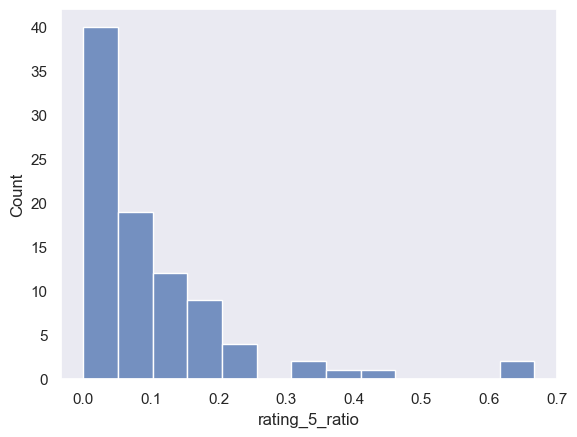

In [103]:
sns.histplot(evals_agg_by_user, x="rating_5_ratio")

<Axes: xlabel='turing_pass', ylabel='Count'>

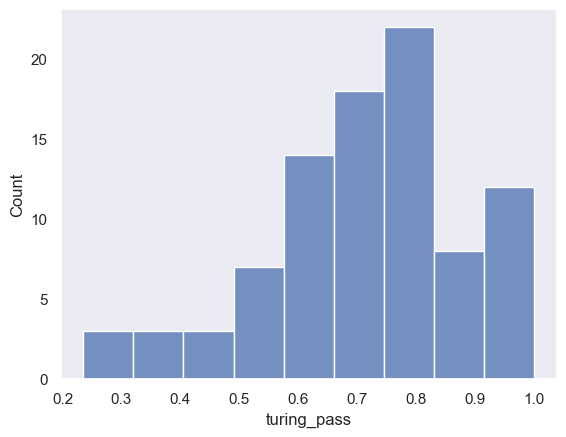

In [91]:
sns.histplot(evals_agg_by_user, x="turing_pass")

In [104]:
evals_agg_by_user_w_session = pd.merge(evals_agg_by_user, sessions, on="user_id", how="left")

In [105]:
evals_agg_by_user_w_session.head()

,user_id,creativity_1,creativity_2,creativity_3,creativity_4,creativity_5,originality_1,originality_2,originality_3,originality_4,...,rating_2_ratio,rating_3_ratio,rating_4_ratio,rating_5_ratio,session_id,starttime,endtime,status,eval_comments,comments
0,2,0.0000,0.000000,0.000000,0.000000,1.000000,0.000,0.000000,1.000000,0.000000,...,0.000000,0.250000,0.500000,0.250000,2,2025-01-13 09:16:42,2025-01-13 09:41:57,completed,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...
1,3,0.0000,0.500000,0.500000,0.000000,0.000000,0.000,0.500000,0.500000,0.000000,...,0.375000,0.500000,0.000000,0.000000,3,2025-01-13 09:17:08,2025-01-13 09:34:20,completed,I took guesses based on how I thought a human ...,Story 17 didn't use the prescribed words. I to...
2,4,0.0000,0.000000,0.000000,0.000000,1.000000,0.000,0.000000,0.000000,0.000000,...,0.083333,0.083333,0.166667,0.666667,4,2025-01-13 09:18:36,2025-01-13 09:40:58,completed,the over complicated stories I think are more ...,NaN
3,6,0.0000,0.210526,0.263158,0.052632,0.473684,0.000,0.052632,0.421053,0.105263,...,0.171053,0.342105,0.118421,0.368421,6,2025-01-13 13:45:22,2025-01-13 14:06:56,completed,"When prompt is made to AI to ""write a story"" i...",Nil
4,7,0.3125,0.187500,0.062500,0.437500,0.000000,0.125,0.375000,0.000000,0.500000,...,0.296875,0.140625,0.343750,0.015625,7,2025-01-13 13:45:34,2025-01-13 13:58:13,completed,"The AI writing, as I interpreted it was more f...",NaN


In [106]:
evals_agg_by_user_w_session["study_time"] = pd.to_datetime(evals_agg_by_user_w_session["endtime"]) - pd.to_datetime(evals_agg_by_user_w_session["starttime"])
evals_agg_by_user_w_session["study_time"].apply(lambda x: x.total_seconds() / 60)

0     25.250000
1     17.200000
2     22.366667
3     21.566667
4     12.650000
        ...    
85    26.200000
86    29.716667
87    18.500000
88    13.150000
89     7.800000
Name: study_time, Length: 90, dtype: float64

In [107]:
evals_agg_by_user_w_session["study_time_in_mins"] = evals_agg_by_user_w_session["study_time"].apply(lambda x: x.total_seconds() / 60)

<Axes: xlabel='study_time_in_mins', ylabel='rating_5_ratio'>

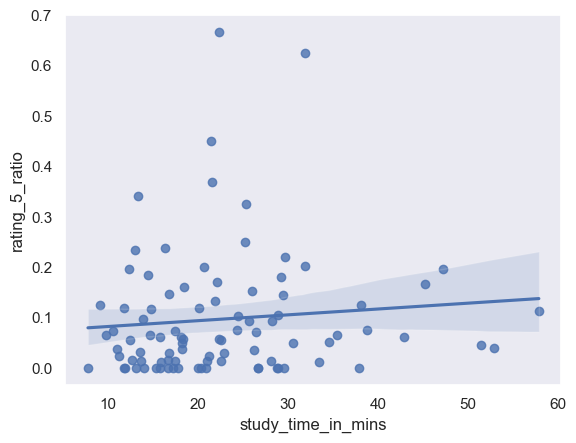

In [112]:
sns.regplot(data=evals_agg_by_user_w_session, x="study_time_in_mins", y="rating_5_ratio")

<Axes: xlabel='study_time_in_mins', ylabel='turing_pass'>

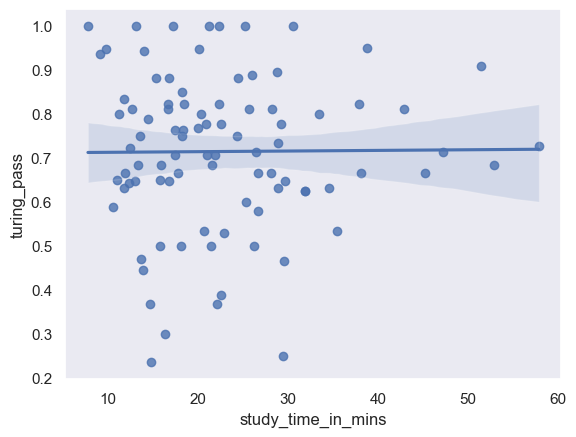

In [113]:
sns.regplot(data=evals_agg_by_user_w_session, x="study_time_in_mins", y="turing_pass")

In [318]:
len(evals_agg_by_user_w_session[evals_agg_by_user_w_session["study_time_in_mins"] > 10])

87

In [321]:
evals.head()

,eval_id,user_id,story_id,session_id,status,creativity,originality,surprise,value,author,story_ext_id,story_item_id,story_author,turing_pass
21,46,2,12,2,completed,5.0,3.0,4.0,4.0,AI,b3f45a6140f9,gloom-payment-exist,AI,True
35,60,3,252,3,completed,2.0,2.0,2.0,3.0,human,R_8LtUJwc0nMwsLzG_Q1,petrol-diesel-pump,human,True
38,63,3,11,3,completed,3.0,3.0,3.0,1.0,AI,b65a1a3c906d,organ-empire-comply,AI,True
57,82,4,252,4,completed,5.0,5.0,5.0,5.0,human,R_8LtUJwc0nMwsLzG_Q1,petrol-diesel-pump,human,True
64,89,4,11,4,completed,5.0,5.0,3.0,2.0,AI,b65a1a3c906d,organ-empire-comply,AI,True


In [322]:
evals_w_session = pd.merge(evals, sessions, on=["user_id", "session_id"], how="left")
evals_w_session["study_time"] = pd.to_datetime(evals_w_session["endtime"]) - pd.to_datetime(evals_w_session["starttime"])
evals_w_session["study_time_in_mins"] = evals_w_session["study_time"].apply(lambda x: x.total_seconds() / 60)

In [323]:
evals_w_session.head()

,eval_id,user_id,story_id,session_id,status_x,creativity,originality,surprise,value,author,...,story_item_id,story_author,turing_pass,starttime,endtime,status_y,eval_comments,comments,study_time,study_time_in_mins
0,46,2,12,2,completed,5.0,3.0,4.0,4.0,AI,...,gloom-payment-exist,AI,True,2025-01-13 09:16:42,2025-01-13 09:41:57,completed,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.250000
1,60,3,252,3,completed,2.0,2.0,2.0,3.0,human,...,petrol-diesel-pump,human,True,2025-01-13 09:17:08,2025-01-13 09:34:20,completed,I took guesses based on how I thought a human ...,Story 17 didn't use the prescribed words. I to...,0 days 00:17:12,17.200000
2,63,3,11,3,completed,3.0,3.0,3.0,1.0,AI,...,organ-empire-comply,AI,True,2025-01-13 09:17:08,2025-01-13 09:34:20,completed,I took guesses based on how I thought a human ...,Story 17 didn't use the prescribed words. I to...,0 days 00:17:12,17.200000
3,82,4,252,4,completed,5.0,5.0,5.0,5.0,human,...,petrol-diesel-pump,human,True,2025-01-13 09:18:36,2025-01-13 09:40:58,completed,the over complicated stories I think are more ...,NaN,0 days 00:22:22,22.366667
4,89,4,11,4,completed,5.0,5.0,3.0,2.0,AI,...,organ-empire-comply,AI,True,2025-01-13 09:18:36,2025-01-13 09:40:58,completed,the over complicated stories I think are more ...,NaN,0 days 00:22:22,22.366667


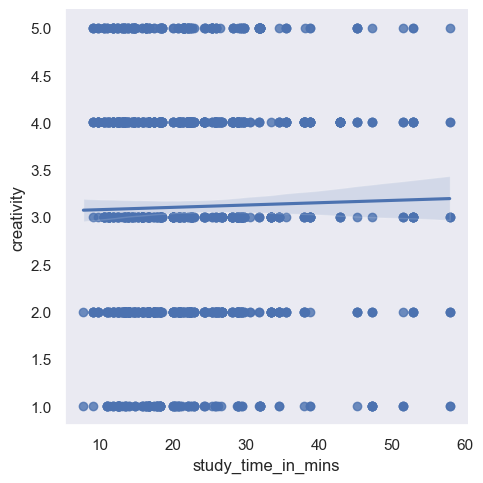

In [ ]:
sns.lmplot(data=evals_w_session, x="study_time_in_mins", y="creativity")

In [116]:
with open("sessions.txt", "w") as f:
    for i, row in sessions.iterrows():
        f.write(f"User: {row['user_id']}, Session: {row['session_id']}, Study time (mins): {row['study_time'].total_seconds() / 60}\n")
        f.write("Eval comments:\n")
        f.write(f"\t{row['eval_comments']}\n")
        f.write("Comments:\n")
        f.write(f"\t{row['comments']}\n")
        f.write("\n\n")

In [115]:
evals_tp = evals.groupby("story_id").agg({"turing_pass": "sum", "eval_id": "count"}).reset_index()
evals_tp["turing_pass_rate"] = evals_tp["turing_pass"] / evals_tp["eval_id"]

In [116]:
evals_tp = pd.merge(evals_tp, stories, on="story_id", how="left")

In [117]:
evals_tp

,story_id,turing_pass,eval_id,turing_pass_rate,story_ext_id,story_item_id,story_author
0,11,4,5,0.8,b65a1a3c906d,organ-empire-comply,AI
1,12,3,5,0.6,b3f45a6140f9,gloom-payment-exist,AI
2,13,4,5,0.8,9ce846e0b789,petrol-diesel-pump,AI
3,14,5,5,1.0,c4209d4234e9,stamp-letter-send,AI
4,15,5,5,1.0,65a333f5aa4b,organ-empire-comply,AI
...,...,...,...,...,...,...,...
268,427,3,5,0.6,R_2mqjhNO26XNoi6R_Q4,gloom-payment-exist,human
269,428,5,5,1.0,R_8DSuE0JfUBgPxHX_Q1,petrol-diesel-pump,human
270,430,4,5,0.8,R_8DSuE0JfUBgPxHX_Q3,organ-empire-comply,human
271,432,4,5,0.8,R_2LTbPAQf8NZ0wRb_Q1,petrol-diesel-pump,human


In [118]:
confusing_evals = evals_tp[evals_tp["turing_pass_rate"] < 0.5]
confusing_story_ext_ids = confusing_evals.sort_values("turing_pass_rate").story_ext_id.to_list()
confusing_pass_rates = confusing_evals.sort_values("turing_pass_rate").turing_pass_rate.to_list()

In [119]:
confusing_evals["story_author"].value_counts()

story_author
AI       36
human    16
Name: count, dtype: int64

In [120]:
len(confusing_story_ext_ids)

52

In [121]:
eval_data = read_json("../experiments/human_eval/eval_data.json")

with open("confusing_stories.txt", "w") as f:
    for ext_id, pass_rate in zip(confusing_story_ext_ids, confusing_pass_rates):
        story_data = eval_data[ext_id]
        f.write(f"Story: {ext_id}, Turing pass rate: {pass_rate}\n")
        f.write(f"\t{story_data['text']}\n")
        f.write("\n\n")

In [246]:
evals

,eval_id,user_id,story_id,session_id,status,creativity,originality,surprise,value,author,story_ext_id,story_item_id,story_author,turing_pass
21,46,2,12,2,completed,5.0,3.0,4.0,4.0,AI,b3f45a6140f9,gloom-payment-exist,AI,True
35,60,3,252,3,completed,2.0,2.0,2.0,3.0,human,R_8LtUJwc0nMwsLzG_Q1,petrol-diesel-pump,human,True
38,63,3,11,3,completed,3.0,3.0,3.0,1.0,AI,b65a1a3c906d,organ-empire-comply,AI,True
57,82,4,252,4,completed,5.0,5.0,5.0,5.0,human,R_8LtUJwc0nMwsLzG_Q1,petrol-diesel-pump,human,True
64,89,4,11,4,completed,5.0,5.0,3.0,2.0,AI,b65a1a3c906d,organ-empire-comply,AI,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122,2219,98,432,98,completed,4.0,2.0,3.0,4.0,human,R_2LTbPAQf8NZ0wRb_Q1,petrol-diesel-pump,human,True
2124,2221,98,434,98,completed,4.0,4.0,4.0,4.0,human,R_2LTbPAQf8NZ0wRb_Q3,organ-empire-comply,human,True
2126,2223,98,190,98,completed,4.0,4.0,4.0,4.0,AI,e2241b3c75ca,organ-empire-comply,AI,True
2145,2242,99,432,99,completed,1.0,1.0,1.0,1.0,human,R_2LTbPAQf8NZ0wRb_Q1,petrol-diesel-pump,human,True


In [123]:
evals = pd.merge(evals, sessions, on=["user_id", "session_id"], how="left")
evals["study_time"] = pd.to_datetime(evals["endtime"]) - pd.to_datetime(evals["starttime"])
evals["study_time_in_mins"] = evals["study_time"].apply(lambda x: x.total_seconds() / 60)

In [124]:
evals.columns

Index(['eval_id', 'user_id', 'story_id', 'session_id', 'status_x',
       'creativity', 'originality', 'surprise', 'value', 'author',
       'story_ext_id', 'story_item_id', 'story_author', 'turing_pass',
       'starttime', 'endtime', 'status_y', 'eval_comments', 'comments',
       'study_time', 'study_time_in_mins'],
      dtype='object')

In [125]:
evals_by_story = evals.groupby(["story_id", "story_ext_id", "story_item_id", "story_author"]).agg({"eval_id": "count", "user_id": "count", "session_id": "count", "creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean", "study_time_in_mins": "mean", "turing_pass": "sum"}).reset_index()

In [126]:
evals_by_story

,story_id,story_ext_id,story_item_id,story_author,eval_id,user_id,session_id,creativity,originality,surprise,value,study_time_in_mins,turing_pass
0,11,b65a1a3c906d,organ-empire-comply,AI,5,5,5,4.4,4.2,4.0,3.2,16.590000,4
1,12,b3f45a6140f9,gloom-payment-exist,AI,5,5,5,4.8,4.2,4.4,3.8,18.200000,3
2,13,9ce846e0b789,petrol-diesel-pump,AI,5,5,5,4.2,4.0,4.2,3.6,14.790000,4
3,14,c4209d4234e9,stamp-letter-send,AI,5,5,5,4.6,4.2,3.4,3.8,14.790000,5
4,15,65a333f5aa4b,organ-empire-comply,AI,5,5,5,4.2,4.0,2.8,2.6,14.790000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,427,R_2mqjhNO26XNoi6R_Q4,gloom-payment-exist,human,5,5,5,2.8,2.2,1.8,3.6,43.590000,3
269,428,R_8DSuE0JfUBgPxHX_Q1,petrol-diesel-pump,human,5,5,5,2.0,1.8,1.6,2.4,45.833333,5
270,430,R_8DSuE0JfUBgPxHX_Q3,organ-empire-comply,human,5,5,5,2.2,2.0,2.0,2.8,43.590000,4
271,432,R_2LTbPAQf8NZ0wRb_Q1,petrol-diesel-pump,human,5,5,5,1.8,1.6,1.6,2.4,35.496667,4


In [127]:
evals_by_story.groupby("story_author").agg({"creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean", "study_time_in_mins": "mean"}).reset_index()

,story_author,creativity,originality,surprise,value,study_time_in_mins
0,AI,3.622695,3.405674,2.990071,3.243972,22.623570
1,human,2.559091,2.621212,2.309091,2.757576,22.721338


In [1]:
from utils import read_json, find_files

metric_data = {}
metrics_dir = "../experiments/reports/pilot3/main_report"
json_files = find_files(metrics_dir, "json")
metrics = set()

for json_file in json_files:
    contents = read_json(json_file)
    if "data" in contents:
        for result in contents["data"]:
            metric_data[result["result_id"]] = result["metrics"]
            metrics.update(list(result["metrics"].keys()))

In [2]:
len(metrics), len(metric_data.values())

(41, 431)

In [130]:
for metric in metrics:
    evals_by_story[f"metric_{metric}"] = evals_by_story["story_ext_id"].apply(lambda x: metric_data[x].get(metric))

In [131]:
evals_by_story.head()

,story_id,story_ext_id,story_item_id,story_author,eval_id,user_id,session_id,creativity,originality,surprise,...,metric_length_in_sentences,metric_avg_sentence_length_in_chars,metric_avg_sentence_length_in_words,metric_readability_flesch_ease,metric_length_in_second_person,metric_surprise,metric_avg_dep_num_clauses,metric_readability_flesch_kincaid,metric_length_in_third_person_singular,metric_length_in_chars
0,11,b65a1a3c906d,organ-empire-comply,AI,5,5,5,4.4,4.2,4.0,...,5,161.8,27.6,67.078755,0,0.004591,4.0,11.803195,1,813
1,12,b3f45a6140f9,gloom-payment-exist,AI,5,5,5,4.8,4.2,4.4,...,5,107.6,19.6,86.914769,0,0.018903,2.4,6.949675,3,542
2,13,9ce846e0b789,petrol-diesel-pump,AI,5,5,5,4.2,4.0,4.2,...,5,130.4,22.8,81.339000,0,0.010978,3.4,8.472667,7,656
3,14,c4209d4234e9,stamp-letter-send,AI,5,5,5,4.6,4.2,3.4,...,5,165.0,28.0,62.388065,0,0.017265,6.2,12.258710,4,829
4,15,65a333f5aa4b,organ-empire-comply,AI,5,5,5,4.2,4.0,2.8,...,5,136.6,22.8,63.306538,0,0.007362,2.6,10.888462,2,687


In [3]:
metrics

{'avg_constituency_tree_depth',
 'avg_dep_num_clauses',
 'avg_dep_path_length',
 'avg_pos_adj_ratio',
 'avg_pos_adp_ratio',
 'avg_pos_adv_ratio',
 'avg_pos_det_ratio',
 'avg_pos_noun_ratio',
 'avg_pos_pron_ratio',
 'avg_pos_verb_ratio',
 'avg_sentence_length_in_chars',
 'avg_sentence_length_in_unique_words',
 'avg_sentence_length_in_words',
 'avg_word_length_in_chars',
 'dsi',
 'inv_homogen',
 'length_in_chars',
 'length_in_concepts',
 'length_in_first_person',
 'length_in_first_person_plural',
 'length_in_first_person_singular',
 'length_in_second_person',
 'length_in_sentences',
 'length_in_third_person',
 'length_in_third_person_plural',
 'length_in_third_person_singular',
 'length_in_unique_words',
 'length_in_words',
 'max_constituency_tree_depth',
 'max_dep_num_clauses',
 'max_dep_path_length',
 'n_gram_diversity',
 'novelty',
 'pos_diversity',
 'raw_surprises',
 'readability_flesch_ease',
 'readability_flesch_kincaid',
 'surprise',
 'theme_cluster',
 'theme_uniqueness',
 'type_t

In [5]:
from statistics import mean
import pandas as pd

auto_metrics = [
 'avg_constituency_tree_depth',
 'avg_dep_num_clauses',
 'avg_dep_path_length',
 'avg_pos_adj_ratio',
 'avg_pos_adp_ratio',
 'avg_pos_adv_ratio',
 'avg_pos_det_ratio',
 'avg_pos_noun_ratio',
 'avg_pos_pron_ratio',
 'avg_pos_verb_ratio',
 'avg_sentence_length_in_chars',
 'avg_sentence_length_in_unique_words',
 'avg_sentence_length_in_words',
 'avg_word_length_in_chars',
 'dsi',
 'inv_homogen',
 'length_in_chars',
 'length_in_concepts',
 'length_in_first_person',
 'length_in_first_person_plural',
 'length_in_first_person_singular',
 'length_in_second_person',
 'length_in_sentences',
 'length_in_third_person',
 'length_in_third_person_plural',
 'length_in_third_person_singular',
 'length_in_unique_words',
 'length_in_words',
 'max_constituency_tree_depth',
 'max_dep_num_clauses',
 'max_dep_path_length',
 'novelty',
 'readability_flesch_ease',
 'readability_flesch_kincaid',
 'surprise',
 'theme_uniqueness',
 'n_gram_diversity']

autometric_data = []

for result_id, metrics in metric_data.items():
    autometric_row = {"story_ext_id": result_id}
    for metric in auto_metrics:
        metric_value = metrics.get(metric)
        autometric_row[metric] = mean(metric_value) if isinstance(metric_value, list) else metric_value
    autometric_data.append(autometric_row)

autometric_data = pd.DataFrame(autometric_data)
autometric_data.head()

,story_ext_id,avg_constituency_tree_depth,avg_dep_num_clauses,avg_dep_path_length,avg_pos_adj_ratio,avg_pos_adp_ratio,avg_pos_adv_ratio,avg_pos_det_ratio,avg_pos_noun_ratio,avg_pos_pron_ratio,...,length_in_words,max_constituency_tree_depth,max_dep_num_clauses,max_dep_path_length,novelty,readability_flesch_ease,readability_flesch_kincaid,surprise,theme_uniqueness,n_gram_diversity
0,3ee8b18a7400,8.4,2.80,3.029827,0.047071,0.151408,0.039037,0.171610,0.256197,0.111860,...,109,10,4,9,0.015276,78.095140,8.378579,0.023965,0.125000,0.932110
1,0836151db197,9.5,2.00,2.808163,0.068075,0.105936,0.013158,0.154094,0.271706,0.092992,...,91,11,4,6,0.010470,73.068077,9.526923,0.007789,0.076923,0.945006
2,8b24947ada08,9.0,2.75,3.257363,0.106703,0.080096,0.017857,0.225996,0.288709,0.035240,...,81,13,4,11,0.010842,74.084539,8.826184,0.019478,0.090909,0.945648
3,05709c632822,10.0,5.50,3.499656,0.089019,0.106710,0.072174,0.137667,0.226411,0.041217,...,121,13,8,10,0.021132,66.859182,12.194041,0.019079,0.200000,0.915592
4,6c779472cc45,10.4,2.60,2.968454,0.066433,0.056433,0.028216,0.172113,0.280257,0.055294,...,96,14,5,8,0.011963,79.966057,7.372340,0.012957,0.076923,0.939561


In [6]:
autometric_data.tail()

,story_ext_id,avg_constituency_tree_depth,avg_dep_num_clauses,avg_dep_path_length,avg_pos_adj_ratio,avg_pos_adp_ratio,avg_pos_adv_ratio,avg_pos_det_ratio,avg_pos_noun_ratio,avg_pos_pron_ratio,...,length_in_words,max_constituency_tree_depth,max_dep_num_clauses,max_dep_path_length,novelty,readability_flesch_ease,readability_flesch_kincaid,surprise,theme_uniqueness,n_gram_diversity
426,R_8IgTefujpZYzrxD_Q3,9.600000,2.20,2.942020,0.078989,0.116788,0.016234,0.109509,0.167582,0.108210,...,92,16,3,9,0.006477,75.042505,7.910019,0.010458,0.500000,0.934687
427,R_2VPJFAhkG6jzuXy_Q3,8.250000,2.50,2.663701,0.033333,0.100420,0.050000,0.131793,0.196919,0.127451,...,54,11,5,6,0.014572,91.500512,4.285369,0.005638,0.142857,0.959259
428,R_8WxkYgki5yinZhV_Q3,10.666667,2.00,3.101728,0.045322,0.149854,0.038377,0.153143,0.209064,0.153509,...,59,12,3,9,0.003178,86.148571,6.460317,0.027968,0.142857,0.932086
429,R_8v92A9H3hnaw1QI_Q3,11.250000,2.75,3.670002,0.094753,0.106171,0.056400,0.106171,0.194085,0.159284,...,84,15,6,11,0.011238,71.253640,8.972610,0.010538,0.125000,0.935657
430,R_8B3zak55aPwmX5t_Q3,9.000000,3.75,2.755527,0.103556,0.070487,0.061228,0.139042,0.214108,0.079747,...,73,12,6,7,0.011955,78.762857,7.490476,0.004983,0.142857,0.923097


In [37]:
len(autometric_data)

431

In [7]:
autometric_data.to_csv("../human_eval/autometric_data.csv", index=False)

In [133]:
import matplotlib.pyplot as plt
import pathlib

auto_metrics = [
 'avg_constituency_tree_depth',
 'avg_dep_num_clauses',
 'avg_dep_path_length',
 'avg_pos_adj_ratio',
 'avg_pos_adp_ratio',
 'avg_pos_adv_ratio',
 'avg_pos_det_ratio',
 'avg_pos_noun_ratio',
 'avg_pos_pron_ratio',
 'avg_pos_verb_ratio',
 'avg_sentence_length_in_chars',
 'avg_sentence_length_in_unique_words',
 'avg_sentence_length_in_words',
 'avg_word_length_in_chars',
 'dsi',
 'inv_homogen',
 'length_in_chars',
 'length_in_concepts',
 'length_in_first_person',
 'length_in_first_person_plural',
 'length_in_first_person_singular',
 'length_in_second_person',
 'length_in_sentences',
 'length_in_third_person',
 'length_in_third_person_plural',
 'length_in_third_person_singular',
 'length_in_unique_words',
 'length_in_words',
 'max_constituency_tree_depth',
 'max_dep_num_clauses',
 'max_dep_path_length',
 'novelty',
 'readability_flesch_ease',
 'readability_flesch_kincaid',
 'surprise',
 'theme_uniqueness']
manual_metrics = ["creativity", "originality", "surprise", "value"]
output_dir = pathlib.Path("../human_eval/figures/auto_corrs")

for manual_metric in manual_metrics:
    metric_output_dir = output_dir / manual_metric
    metric_output_dir.mkdir(parents=True, exist_ok=True)
    for auto_metric in auto_metrics:
        sns.lmplot(data=evals_by_story, x=f"metric_{auto_metric}", y=manual_metric, hue="story_author")
        plt.savefig(metric_output_dir / f"{manual_metric}_{auto_metric}.png")
        plt.close()


In [39]:
story_data = read_json("../experiments/human_eval/eval_data.json")
story_data = list(story_data.values())
story_data = pd.DataFrame(story_data)
story_data.head()

,id,text,item_id,author
0,976672582036,In a world where petrol and diesel were sentie...,petrol-diesel-pump,AI
1,9ca6a441cfd5,"In the heart of a bustling city, a solitary st...",stamp-letter-send,AI
2,25795f8e5bee,"Once upon a time, in a world where organs coul...",organ-empire-comply,AI
3,d75a72efa018,"In the heart of the ancient forest, where the ...",gloom-payment-exist,AI
4,7c8448fb1129,"Once upon a time, in a small village, there wa...",petrol-diesel-pump,AI


In [40]:
story_data = story_data.rename(columns={"id": "story_ext_id", "item_id": "story_item_id", "text": "story_text", "author": "story_author"})

In [41]:
story_data.to_csv("../human_eval/story_data.csv", index=False)

In [134]:
manual_metrics = ["creativity", "originality", "surprise", "value"]
output_dir = pathlib.Path("../human_eval/figures/man_corrs")

for manual_metric1 in manual_metrics:
    metric_output_dir = output_dir / manual_metric1
    metric_output_dir.mkdir(parents=True, exist_ok=True)
    for manual_metric2 in manual_metrics:
        if manual_metric1 == manual_metric2:
            continue
        sns.lmplot(data=evals_by_story, x=manual_metric1, y=manual_metric2, hue="story_author")
        plt.savefig(metric_output_dir / f"{manual_metric1}_{manual_metric2}.png")
        plt.close()

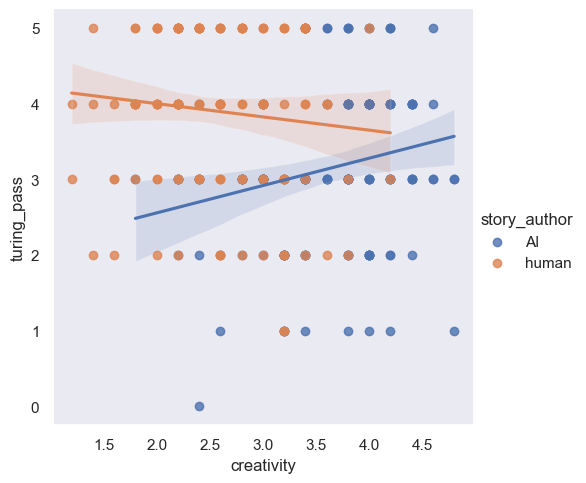

In [137]:
sns.lmplot(data=evals_by_story, x="creativity", y="turing_pass", hue="story_author")

In [140]:
top5_ai = evals_by_story.sort_values(["creativity", "originality", "surprise", "value"], ascending=False).query("story_author == 'AI'").head(5)

with open("../human_eval/top5_ai.txt", "w") as f:
    for i, row in top5_ai.iterrows():
        story_data = eval_data[row["story_ext_id"]]
        f.write(f"Story: {row['story_ext_id']}\n")
        f.write(f"\tCreativity: {row['creativity']}, Originality: {row['originality']}, Surprise: {row['surprise']}, Value: {row['value']}\n")
        f.write(f"\t{story_data['text']}\n")
        f.write("\n\n")

In [143]:
bottom5_ai = evals_by_story.sort_values(["creativity", "originality", "surprise", "value"], ascending=True).query("story_author == 'AI'").head(5)

with open("../human_eval/bottom5_ai.txt", "w") as f:
    for i, row in bottom5_ai.iterrows():
        story_data = eval_data[row["story_ext_id"]]
        f.write(f"Story: {row['story_ext_id']}\n")
        f.write(f"\tCreativity: {row['creativity']}, Originality: {row['originality']}, Surprise: {row['surprise']}, Value: {row['value']}\n")
        f.write(f"\t{story_data['text']}\n")
        f.write("\n\n")

In [142]:
top5_human = evals_by_story.sort_values(["creativity", "originality", "surprise", "value"], ascending=False).query("story_author == 'human'").head(5)

with open("../human_eval/top5_human.txt", "w") as f:
    for i, row in top5_human.iterrows():
        story_data = eval_data[row["story_ext_id"]]
        f.write(f"Story: {row['story_ext_id']}\n")
        f.write(f"\tCreativity: {row['creativity']}, Originality: {row['originality']}, Surprise: {row['surprise']}, Value: {row['value']}\n")
        f.write(f"\t{story_data['text']}\n")
        f.write("\n\n")

In [144]:
bottom5_human = evals_by_story.sort_values(["creativity", "originality", "surprise", "value"], ascending=True).query("story_author == 'human'").head(5)

with open("../human_eval/bottom5_human.txt", "w") as f:
    for i, row in bottom5_human.iterrows():
        story_data = eval_data[row["story_ext_id"]]
        f.write(f"Story: {row['story_ext_id']}\n")
        f.write(f"\tCreativity: {row['creativity']}, Originality: {row['originality']}, Surprise: {row['surprise']}, Value: {row['value']}\n")
        f.write(f"\t{story_data['text']}\n")
        f.write("\n\n")

In [16]:
import pandas as pd

evals_claire = pd.read_csv("../human_eval/csg-human-eval-claire.csv")
evals_mete = pd.read_csv("../human_eval/csg-human-eval-mete.csv")
evals_lonneke = pd.read_csv("../human_eval/csg-human-eval-lonneke.csv")
evals_non_expert = pd.read_csv("../human_eval/raw_non_expert_data.csv")

In [17]:
evals_non_expert_by_story = evals_non_expert.groupby(["story_id", "story_ext_id", "story_item_id", "story_author"]).agg({"eval_id": "count", "user_id": "count", "session_id": "count", "creativity": "mean", "originality": "mean", "surprise": "mean", "value": "mean", "study_time_in_mins": "mean"}).reset_index()

In [18]:
evals_non_expert

,eval_id,user_id,story_id,session_id,creativity,originality,surprise,value,pred_author,story_ext_id,story_item_id,story_author,starttime,endtime,eval_comments,comments,study_time,study_time_in_mins,control_story
0,25,2,253,2,5.0,4.0,2.0,4.0,human,R_8LtUJwc0nMwsLzG_Q2,stamp-letter-send,human,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25,True
1,26,2,6,2,2.0,1.0,1.0,3.0,AI,f3ec3e93fa8b,stamp-letter-send,AI,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25,False
2,27,2,2,2,4.0,5.0,4.0,4.0,AI,9ca6a441cfd5,stamp-letter-send,AI,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25,False
3,28,2,245,2,2.0,4.0,2.0,2.0,human,R_8WxkYgki5yinZhV_Q2,stamp-letter-send,human,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25,False
4,29,2,121,2,5.0,5.0,2.0,4.0,human,4550c7034f90,stamp-letter-send,AI,2025-01-13 09:16:42,2025-01-13 09:41:57,Thought that more original or unusual stories ...,Some of the stories only contained one of the ...,0 days 00:25:15,25.25,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2252,99,199,99,3.0,3.0,3.0,2.0,AI,e92151311c22,gloom-payment-exist,AI,2025-01-13 15:30:31,2025-01-13 15:38:19,"I distinguished AI writing by repetitive, gran...",NaN,0 days 00:07:48,7.80,False
2156,2253,99,79,99,2.0,2.0,2.0,1.0,AI,13f2217b9d4c,gloom-payment-exist,AI,2025-01-13 15:30:31,2025-01-13 15:38:19,"I distinguished AI writing by repetitive, gran...",NaN,0 days 00:07:48,7.80,True
2157,2254,99,431,99,1.0,1.0,1.0,1.0,human,R_8DSuE0JfUBgPxHX_Q4,gloom-payment-exist,human,2025-01-13 15:30:31,2025-01-13 15:38:19,"I distinguished AI writing by repetitive, gran...",NaN,0 days 00:07:48,7.80,False
2158,2255,99,435,99,1.0,1.0,1.0,1.0,human,R_2LTbPAQf8NZ0wRb_Q4,gloom-payment-exist,human,2025-01-13 15:30:31,2025-01-13 15:38:19,"I distinguished AI writing by repetitive, gran...",NaN,0 days 00:07:48,7.80,False


In [19]:
evals_claire.head()

,Item ID,Story,Creativity,Originality,Surprise,Effectiveness,Author,story_ext_id
0,stamp-letter-send,"In the quaint village of Stamptown, letters we...",3,4,3,3,AI,8d4cce7f122d
1,NaN,Yesterday I received a letter in the post. As ...,4,4,4,5,human,R_8U0c5Ms0PJ9VYTm_Q2
2,NaN,"In the mystical realm of Echoia, the ancient s...",3,4,3,3,AI,4550c7034f90
3,NaN,Emma wanted to send a message to the public ab...,4,3,3,4,human,R_8LtUJwc0nMwsLzG_Q2
4,petrol-diesel-pump,"The old diesel engine rumbled to life, and the...",3,3,2,4,AI,e7745b30528b


In [20]:
evals_claire = evals_claire.rename(columns={"Creativity": "creativity", "Originality": "originality", "Surprise": "surprise", "Effectiveness": "value", "Author": "pred_author"})
evals_mete = evals_mete.rename(columns={"Creativity": "creativity", "Originality": "originality", "Surprise": "surprise", "Effectiveness": "value", "Author": "pred_author"})
evals_lonneke = evals_lonneke.rename(columns={"Creativity": "creativity", "Originality": "originality", "Surprise": "surprise", "Effectiveness": "value", "Author": "pred_author"})

In [21]:
evals_claire = evals_claire[["story_ext_id", "creativity", "originality", "surprise", "value", "pred_author"]]
evals_mete = evals_mete[["story_ext_id", "creativity", "originality", "surprise", "value", "pred_author"]]
evals_lonneke = evals_lonneke[["story_ext_id", "creativity", "originality", "surprise", "value", "pred_author"]]

In [22]:
evals_non_expert_by_story = evals_non_expert_by_story[["story_ext_id", "story_author", "creativity", "originality", "surprise", "value"]]

In [15]:
evals_non_expert_by_story

,story_ext_id,story_author,creativity,originality,surprise,value
0,b65a1a3c906d,AI,4.4,4.2,4.0,3.2
1,b3f45a6140f9,AI,4.8,4.2,4.4,3.8
2,9ce846e0b789,AI,4.2,4.0,4.2,3.6
3,c4209d4234e9,AI,4.6,4.2,3.4,3.8
4,65a333f5aa4b,AI,4.2,4.0,2.8,2.6
...,...,...,...,...,...,...
268,R_2mqjhNO26XNoi6R_Q4,human,2.8,2.2,1.8,3.6
269,R_8DSuE0JfUBgPxHX_Q1,human,2.0,1.8,1.6,2.4
270,R_8DSuE0JfUBgPxHX_Q3,human,2.2,2.0,2.0,2.8
271,R_2LTbPAQf8NZ0wRb_Q1,human,1.8,1.6,1.6,2.4


In [25]:
control_evals = pd.merge(evals_non_expert_by_story, evals_claire, on="story_ext_id", how="inner", suffixes=("", "_claire"))
control_evals = pd.merge(control_evals, evals_mete, on="story_ext_id", how="inner", suffixes=("", "_mete"))
control_evals = pd.merge(control_evals, evals_lonneke, on="story_ext_id", how="inner", suffixes=("", "_lonneke"))

In [26]:
control_evals

,story_ext_id,story_author,creativity,originality,surprise,value,creativity_claire,originality_claire,surprise_claire,value_claire,...,creativity_mete,originality_mete,surprise_mete,value_mete,pred_author_mete,creativity_lonneke,originality_lonneke,surprise_lonneke,value_lonneke,pred_author_lonneke
0,e7745b30528b,AI,2.863636,2.818182,2.500000,2.954545,3,3,2,4,...,2,1,2,3,AI,2,2,2,2,AI
1,e3e4310f8c04,AI,3.250000,2.875000,2.416667,3.208333,3,3,3,4,...,3,3,3,3,AI,2,2,2,3,human
2,50a0b00eb07f,AI,3.571429,3.095238,2.476190,3.333333,3,4,4,3,...,3,2,3,2,AI,2,2,3,1,AI
3,13f2217b9d4c,AI,3.916667,3.666667,2.916667,3.250000,5,4,5,3,...,3,3,3,3,AI,2,2,3,2,AI
4,4550c7034f90,AI,4.347826,3.956522,3.000000,3.652174,3,4,3,3,...,2,1,2,1,AI,2,1,2,1,AI
5,8d4cce7f122d,AI,3.909091,3.636364,2.681818,3.136364,3,4,3,3,...,2,1,2,2,AI,2,1,2,2,AI
6,2cf519f6ff39,AI,3.714286,3.476190,2.904762,3.333333,3,4,2,3,...,3,3,3,3,AI,2,2,2,1,AI
7,52cade8daeea,AI,3.625000,3.625000,3.375000,3.250000,3,5,3,3,...,2,1,2,2,AI,2,2,3,2,AI
8,R_2Ep8Ymfq8uSEw90_Q4,human,2.120000,2.160000,1.960000,2.880000,4,4,3,3,...,3,3,3,4,human,3,4,2,4,human
9,R_8LtUJwc0nMwsLzG_Q2,human,3.037037,3.000000,2.407407,2.851852,4,3,3,4,...,3,3,2,3,human,4,3,4,4,human


In [27]:
metrics = ["creativity", "originality", "surprise", "value"]
agg_dict = {col: "mean" for col in control_evals.columns if any([m in col for m in metrics])}
control_evals.groupby("story_author").agg(agg_dict)

,creativity,originality,surprise,value,creativity_claire,originality_claire,surprise_claire,value_claire,creativity_mete,originality_mete,surprise_mete,value_mete,creativity_lonneke,originality_lonneke,surprise_lonneke,value_lonneke
story_author,,,,,,,,,,,,,,,,
AI,3.649742,3.393645,2.783888,3.264760,3.250,3.875,3.125,3.250,2.500,1.875,2.5,2.375,2.00,1.750,2.375,1.75
human,2.644262,2.709367,2.310551,2.889295,4.125,3.875,3.750,4.125,3.375,3.000,3.0,3.500,3.25,2.875,3.000,3.25
